# netcdfとxarray

## netcdf

"netcdf"とは気象学・海洋学・気候学の世界でよく利用されているファイルフォーマットであり、
コンピュータのCPUのエンディアンに依存しないバイナリ形式である。
"netcdf"の"classic data model"では、
次元・変数・属性（メタデータ）の３つが構成要素になっている。
属性（メタデータ）がファイルに含まれることにより、
データがどのようなものであり、
単位や座標系がどうなっているのかなどが理解しやすくなっている。

気象学・海洋学・気候学の世界では、データの属性や次元などを共通化し、
データについての自己記述性を高めるため「規約」が定められている。
規約としては、COARDS規約や現在CMIPデータなどで用いられているCF規約が存在する。
COARDS規約やCF規約に従って作成されたnetcdf形式のファイルは、
各種のツールで正しくデータを読み込み、可視化することができる。

netcdf形式のファイルを読み込み、各種処理ができるツールは複数存在する。
例えば、
[GrADS](https://cola.gmu.edu/grads/)、
[IDL](https://nv5geospatialsoftware.com/Products/IDL)、
[MATLAB](https://mathworks.com/products/matlab.html)、
[NCL](https://ncl.ucar.edu/)などが挙げられる。
また、統計言語
[R](https://www.r-project.org/)
やプログラミング言語
[Python](https://www.python.org/)
でもパッケージやモジュールを利用することでnetcdf形式のデータの読み書きが可能である。
また、[cdo](https://code.mpimet.mpg.de/project/cdo)や
[nco](https://nco.sourceforge.net)といったツールも広く利用されている。

## netcdf形式のファイルの中身

ここでは日本域海洋予測データFORPの北太平洋モデルのポテンシャル水温データを例として、ファイルの中身を見てゆく。

In [1]:
!ncdump -h ./Data/forp-np-v4_thetao_mn_200007.sub.nc

netcdf forp-np-v4_thetao_mn_200007.sub {
dimensions:
	time = UNLIMITED ; // (1 currently)
	lon = 771 ;
	lat = 451 ;
	lev = 30 ;
variables:
	double time(time) ;
		time:standard_name = "time" ;
		time:units = "hours since 1-1-1 00:00:00" ;
		time:calendar = "standard" ;
		time:axis = "T" ;
	double lon(lon) ;
		lon:standard_name = "longitude" ;
		lon:long_name = "longitude" ;
		lon:units = "degrees_east" ;
		lon:axis = "X" ;
	double lat(lat) ;
		lat:standard_name = "latitude" ;
		lat:long_name = "latitude" ;
		lat:units = "degrees_north" ;
		lat:axis = "Y" ;
	double lev(lev) ;
		lev:standard_name = "depth" ;
		lev:long_name = "depth_below_sea" ;
		lev:units = "m" ;
		lev:positive = "down" ;
		lev:axis = "Z" ;
	float thetao(time, lev, lat, lon) ;
		thetao:standard_name = "sea_water_potential_temperature" ;
		thetao:long_name = "Sea Water Potential Temperature" ;
		thetao:units = "degC" ;
		thetao:_FillValue = -9.99e+33f ;
		thetao:missing_value = -9.99e+33f ;

// global attributes:
		:CDI 

"dimensions"として次元の情報が記載されている。
"time"は時刻で現在は1時刻、"lon"として経度方向の格子点が2049個、"lat"として緯度方向の格子点が784個、"lev"として鉛直方向の格子点が60個存在することを意味している。

次に"variables"として変数の情報が記載されている。

"time"/"lat"/"lon"/"lev"は"double"と書かれているので、1データ＝8バイトである。
また座標軸であるため"time(time)"のような記述になっている。それぞれに"standard_name"や"long_name"、"unit"、"axis"などの情報が付いている。これらを変数の属性とよぶ。

さて、変数"thetao"には"float"と書かれているので、1データ＝4バイトである。
次に"thetao(time, lev, lat, lon)"と書かれている。
thetaoは4次元であり、座標が時間＝"time"、鉛直層="lev"、緯度="lat"、経度="lon"であることが表示されている。
そして変数の属性として、"standard_name"、"long_name"、"units"、"_FillValue"、"missing_value"が存在している。

"global attributes"はデータ全体についての各種の情報が付加されている。
なお、FORPはできるだけCF規約に従う形でファイルを作成したが、従えなかった部分があるので"global attributes"の"Conventions"が"None"になっている。

## Xarrayの基礎

xarrayは、以下のようなものである。

> Xarray is an open source project and Python package that introduces labels in the form of dimensions, coordinates, and attributes on top of raw NumPy-like arrays, which allows for more intuitive, more concise, and less error-prone user experience.  
> [公式サイト](https://xaray.dev) トップページより

気候データ解析を行う立場からすると、netcdf形式のデータを簡便に取り扱うことができるライブラリである。

### Xarray のデータ構造

xarrayには基本的に二つのデータ構造が存在する。

* DataArray : ひとつの多次元変数とその座標をもつ。
* Dataset : 複数の多次元変数とその座標。ただしすべての変数の間でできるだけ共通する座標をもつ。

#### DataArray

DataArrayには4つの構成要素がある。

* values : numpy.ndarrayに格納されている数値。
* dims : それぞれの座標軸の次元の名前。
* coords : 座標名のコンテナ。
* attrs : 任意のメタデータ、属性。


In [2]:
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import datetime

単純なDataArrayを作成する。

In [3]:
da = xr.DataArray([2, 4, 6, 8, 10])
da

<xarray.DataArray (dim_0: 5)> Size: 40B
array([ 2,  4,  6,  8, 10])
Dimensions without coordinates: dim_0

DataArrayに次元名を付加する。

In [4]:
da = xr.DataArray([2, 4, 6, 8, 10], dims=['x'])
da

<xarray.DataArray (x: 5)> Size: 40B
array([ 2,  4,  6,  8, 10])
Dimensions without coordinates: x

DataArrayに座標を付加する。

In [5]:
da = xr.DataArray([2, 8, 6, 4, 10], 
                  dims=['x'],
                  coords={'x': [10, 20, 30, 40, 50]})
da

<xarray.DataArray (x: 5)> Size: 40B
array([ 2,  8,  6,  4, 10])
Coordinates:
  * x        (x) int64 40B 10 20 30 40 50

XarrayのDataArrayはpandasのデータフレームと同様に簡易作図ができる。

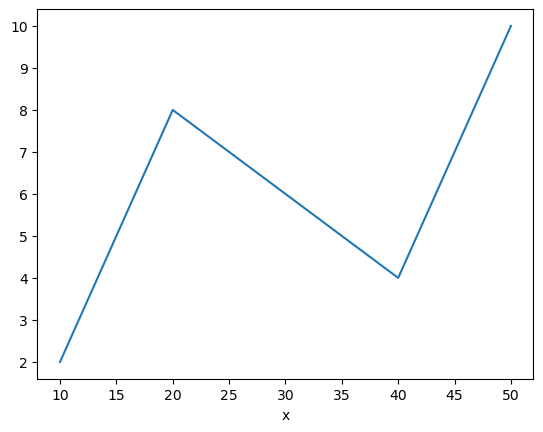

In [6]:
da.plot()

### Dataset

Dataset には一つ以上のDataArrayが含まれている。

FORPデータを``xarray.open_dataset()``を用いて読み込んで構造を見てみる。

In [7]:
ds = xr.open_dataset("./Data/forp-np-v4_thetao_mn_200007.sub.nc")
ds

/home/nobu/miniforge3/envs/xa/lib/python3.12/site-packages/xarray/coding/times.py:187: SerializationWarning: Ambiguous reference date string: 1-1-1 00:00:00. The first value is assumed to be the year hence will be padded with zeros to remove the ambiguity (the padded reference date string is: 0001-1-1 00:00:00). To remove this message, remove the ambiguity by padding your reference date strings with zeros.
  ref_date = _ensure_padded_year(ref_date)


<xarray.Dataset> Size: 42MB
Dimensions:  (time: 1, lon: 771, lat: 451, lev: 30)
Coordinates:
  * time     (time) datetime64[ns] 8B 2000-07-01
  * lon      (lon) float64 6kB 110.0 110.1 110.2 110.3 ... 179.8 179.9 180.0
  * lat      (lat) float64 4kB 15.0 15.1 15.2 15.3 15.4 ... 59.7 59.8 59.9 60.0
  * lev      (lev) float64 240B 1.0 3.5 6.5 10.0 ... 250.0 272.5 300.0 330.0
Data variables:
    thetao   (time, lev, lat, lon) float32 42MB ...
Attributes: (12/13)
    CDI:                     Climate Data Interface version 2.3.0 (https://mp...
    Conventions:             None
    source:                  MRI.COM ver4.6
    institution:             Japan Agency for Marine-Earth Science and Techno...
    title:                   The Future Ocean Regional Projection (FORP) data...
    frequency:               mon
    ...                      ...
    experiment:              historical
    license:                 Creative Commons Attribution 4.0 International L...
    project:                 Integrated Research Program for Advancing Climat...
    format_conversion_date:  Sun Jul 31 13:51:06 JST 2022
    history:                 Mon Nov 25 15:48:10 2024: cdo -f nc4c -z zip_9 c...
    CDO:                     Climate Data Operators version 2.3.0 (https://mp...

先に"ncdump"でファイルの情報を見たときと同じ情報が"ds"に読み込まれている。

このファイルでは、次元数が４個であり、また座標数も４個存在する。
"time"はdatetime64型であり、"lon"/"lat"/"lev"はfloat64（1データ=8バイト）である。
変数"thetao"は"time"/"lev"/"lat"/"lon"の四次元であり、float32（1データ=4バイト）であることがわかる。

``xarray.open_dataset()``を用いることで、簡便にnetcdf形式で格納されているデータを読むことができる。

## xarrayデータとpandasデータフレーム

気象庁の３ヶ所の気象官署（勝浦、熊谷、軽井沢）の気温データを編集したファイルを用いて xarray.Dataset を作成する。

平均気温のデータ（"./Data/K3.Tave.csv"）を``pandas.read_csv()``を用いて読み込む。

In [8]:
df1 = pd.read_csv("./Data/K3.Tave.csv", na_values=[-999.9])
df1.head()

,Date,Katsuura,Kumagaya,Karuizawa
0,1951/1/1,5.7,0.9,-5.5
1,1951/1/2,3.4,1.5,-9.4
2,1951/1/3,4.3,-1.3,-6.9
3,1951/1/4,5.2,0.7,-6.1
4,1951/1/5,4.5,1.0,-5.7


同様に、最低気温のデータ（"./Data/K3.Tmin.csv"）と最高気温のデータ（"./Data/K3.Tmax.csv"）を読み込む。

In [9]:
df2 = pd.read_csv("./Data/K3.Tmin.csv", na_values=[-999.9])
df3 = pd.read_csv("./Data/K3.Tmax.csv", na_values=[-999.9])

３つのデータフレームの形状を確認する。

In [10]:
df1.shape

(26298, 4)

この数値は、行数が26298行で、列数が４列であることを示している。

In [11]:
df2.shape

(26298, 4)

In [12]:
df3.shape

(26298, 4)

日付情報をdatetime64型に変換する。

In [13]:
time = pd.to_datetime(df1['Date'])
time

0       1951-01-01
1       1951-01-02
2       1951-01-03
3       1951-01-04
4       1951-01-05
           ...    
26293   2022-12-27
26294   2022-12-28
26295   2022-12-29
26296   2022-12-30
26297   2022-12-31
Name: Date, Length: 26298, dtype: datetime64[ns]

"location"という軸を作成し、次元として"time"と"location"を用い、座標を定義する。

In [14]:
location = ['Katsuura', 'Kumagaya', 'Karuizawa']
dims = ('time', 'location')
coords = {'time': time, 'location': location}

xarray.DataArrayを作成する。
なお、データフレームから"Date"というcolumnを削除。
columnの削除のために"axis=1"を付ける。

In [15]:
tave = xr.DataArray(df1.drop('Date', axis=1), coords, dims)
tave

<xarray.DataArray (time: 26298, location: 3)> Size: 631kB
array([[ 5.7,  0.9, -5.5],
       [ 3.4,  1.5, -9.4],
       [ 4.3, -1.3, -6.9],
       ...,
       [10.3,  6.9, -0.7],
       [ 7.1,  5.9, -2.6],
       [ 6.9,  4.9, -3.1]])
Coordinates:
  * time      (time) datetime64[ns] 210kB 1951-01-01 1951-01-02 ... 2022-12-31
  * location  (location) <U9 108B 'Katsuura' 'Kumagaya' 'Karuizawa'

日最低気温と日最高気温もDataArrayに変換する。

In [16]:
tmin = xr.DataArray(df2.drop('Date', axis=1), coords, dims)
tmax = xr.DataArray(df3.drop('Date', axis=1), coords, dims)

３つのDataArrayを一つのxarray.Datasetにまとめる。

In [17]:
ds = xr.Dataset()
ds['tave'] = tave
ds['tmin'] = tmin
ds['tmax'] = tmax
ds

<xarray.Dataset> Size: 2MB
Dimensions:   (time: 26298, location: 3)
Coordinates:
  * time      (time) datetime64[ns] 210kB 1951-01-01 1951-01-02 ... 2022-12-31
  * location  (location) <U9 108B 'Katsuura' 'Kumagaya' 'Karuizawa'
Data variables:
    tave      (time, location) float64 631kB 5.7 0.9 -5.5 3.4 ... 6.9 4.9 -3.1
    tmin      (time, location) float64 631kB 1.6 -2.5 -8.9 ... 3.7 -0.7 -6.2
    tmax      (time, location) float64 631kB 10.9 5.0 -3.6 7.3 ... 10.7 11.3 3.3

ある期間のデータを``sel()``を用いて抽出する。

In [18]:
ds2 = ds.sel(time=slice('2000-01-01','2002-01-01'))
ds2

<xarray.Dataset> Size: 59kB
Dimensions:   (time: 732, location: 3)
Coordinates:
  * time      (time) datetime64[ns] 6kB 2000-01-01 2000-01-02 ... 2002-01-01
  * location  (location) <U9 108B 'Katsuura' 'Kumagaya' 'Karuizawa'
Data variables:
    tave      (time, location) float64 18kB 8.5 7.0 -1.9 7.2 ... 9.0 3.2 0.1
    tmin      (time, location) float64 18kB 4.9 1.8 -5.9 4.3 ... 2.8 -2.5 -7.7
    tmax      (time, location) float64 18kB 13.4 12.4 3.7 10.3 ... 13.1 9.9 6.7

勝浦の気温データの時系列を描く。

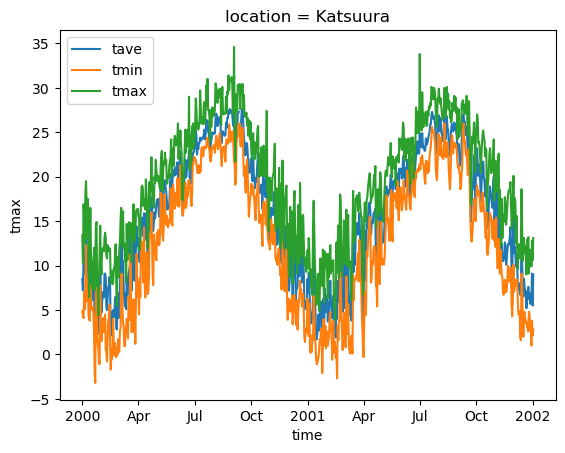

In [19]:
ds3 = ds2.sel(location="Katsuura")
ds3["tave"].plot.line()
ds3["tmin"].plot.line()
ds3["tmax"].plot.line()
plt.legend(["tave","tmin","tmax"])

あまり意味のあることではないが、地点間の平均値を求めて、時系列を描く。

<Axes: xlabel='time'>

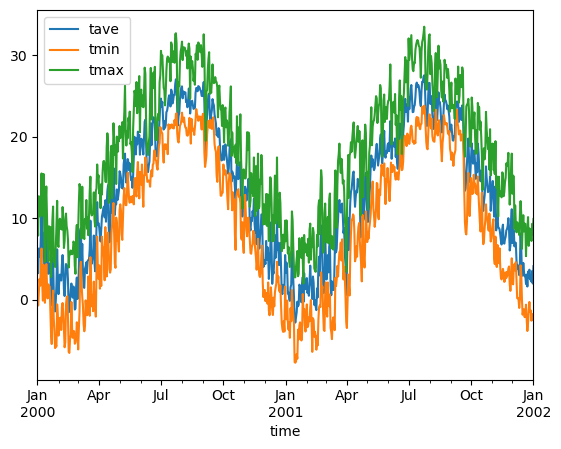

In [20]:
ds2.mean(dim="location").to_dataframe().plot()

日最高気温が摂氏30度を超える頻度を各月ごとに計算して、可視化する。

<Axes: xlabel='month'>

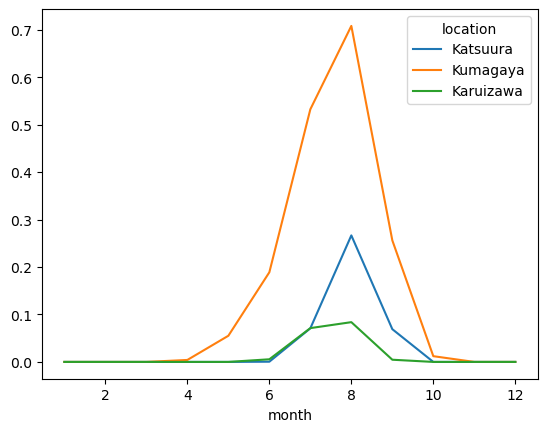

In [21]:
hot = (ds["tmax"] >= 30).groupby("time.month").mean("time")
hot.to_pandas().plot()

xarray.Datasetからある場所の抽出の仕方。以下の二つは同じ結果を得られる。

In [22]:
ds["tmax"][:,1].groupby("time.month").mean("time")

<xarray.DataArray 'tmax' (month: 12)> Size: 96B
array([ 9.41684588, 10.1867126 , 13.57736441, 19.22612321, 23.88158602,
       26.38375   , 29.92939068, 31.64939489, 26.95044002, 21.49910314,
       16.47559055, 11.8546595 ])
Coordinates:
    location  <U9 36B 'Kumagaya'
  * month     (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12

In [23]:
ds.tmax.isel(location=1).groupby("time.month").mean("time")

<xarray.DataArray 'tmax' (month: 12)> Size: 96B
array([ 9.41684588, 10.1867126 , 13.57736441, 19.22612321, 23.88158602,
       26.38375   , 29.92939068, 31.64939489, 26.95044002, 21.49910314,
       16.47559055, 11.8546595 ])
Coordinates:
    location  <U9 36B 'Kumagaya'
  * month     (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12

``resample()``を用いて月平均値を作成する。
なお"1MS"は「１か月。Month Start」を意味する。

In [24]:
monave = ds.resample(time="1MS").mean()
monave

<xarray.Dataset> Size: 69kB
Dimensions:   (time: 864, location: 3)
Coordinates:
  * location  (location) <U9 108B 'Katsuura' 'Kumagaya' 'Karuizawa'
  * time      (time) datetime64[ns] 7kB 1951-01-01 1951-02-01 ... 2022-12-01
Data variables:
    tave      (time, location) float64 21kB 5.281 2.116 -4.932 ... 6.274 -1.058
    tmin      (time, location) float64 21kB 1.255 -2.939 -9.939 ... 1.4 -5.094
    tmax      (time, location) float64 21kB 10.22 8.152 0.1677 ... 12.19 4.416

軽井沢の日平均気温の月平均値の時系列を描く。

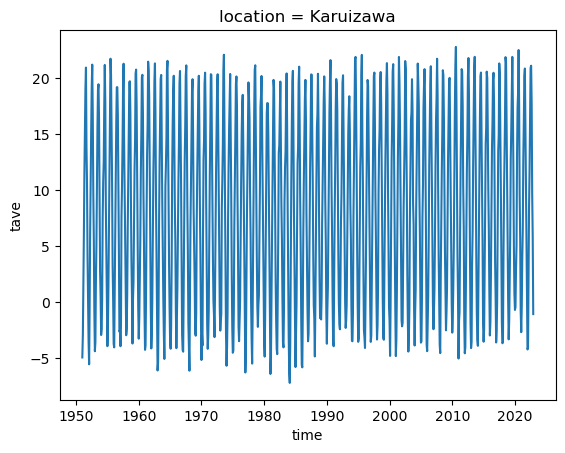

In [25]:
monave["tave"].sel(location="Karuizawa").plot()

1991年から2020年の30年分のデータを用いて気候値を作成する。

In [26]:
clim = (monave
        .sel(time=slice("1991-01-01","2020-12-31"))
        .groupby("time.month")
        .mean("time"))
clim

<xarray.Dataset> Size: 1kB
Dimensions:   (month: 12, location: 3)
Coordinates:
  * location  (location) <U9 108B 'Katsuura' 'Kumagaya' 'Karuizawa'
  * month     (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    tave      (month, location) float64 288B 6.756 4.282 ... 6.537 -0.5567
    tmin      (month, location) float64 288B 2.922 -0.3926 ... 1.799 -5.288
    tmax      (month, location) float64 288B 11.08 9.808 2.315 ... 12.0 5.326

偏差を求める。

In [27]:
anom = monave.groupby("time.month") - clim
anom

<xarray.Dataset> Size: 76kB
Dimensions:   (location: 3, time: 864)
Coordinates:
  * location  (location) <U9 108B 'Katsuura' 'Kumagaya' 'Karuizawa'
  * time      (time) datetime64[ns] 7kB 1951-01-01 1951-02-01 ... 2022-12-01
    month     (time) int64 7kB 1 2 3 4 5 6 7 8 9 10 ... 3 4 5 6 7 8 9 10 11 12
Data variables:
    tave      (time, location) float64 21kB -1.475 -2.165 ... -0.2623 -0.5014
    tmin      (time, location) float64 21kB -1.667 -2.546 ... -0.399 0.1941
    tmax      (time, location) float64 21kB -0.8589 -1.656 ... 0.1932 -0.9098

熊谷の気候値を描いてみる。

<Axes: xlabel='month'>

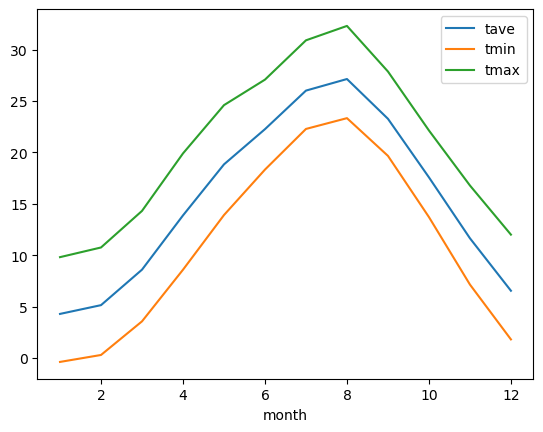

In [28]:
clim.sel(location="Kumagaya").to_dataframe().plot()

８月のデータを抽出する。

In [29]:
anom_aug = anom.sel(time=anom["time.month"]==8)
anom_aug

<xarray.Dataset> Size: 6kB
Dimensions:   (location: 3, time: 72)
Coordinates:
  * location  (location) <U9 108B 'Katsuura' 'Kumagaya' 'Karuizawa'
  * time      (time) datetime64[ns] 576B 1951-08-01 1952-08-01 ... 2022-08-01
    month     (time) int64 576B 8 8 8 8 8 8 8 8 8 8 8 ... 8 8 8 8 8 8 8 8 8 8 8
Data variables:
    tave      (time, location) float64 2kB -0.3694 -0.9104 ... 0.5283 0.3278
    tmin      (time, location) float64 2kB -0.4639 -0.6108 ... 0.5312 0.9287
    tmax      (time, location) float64 2kB 0.1536 -0.5966 ... 0.3002 -0.134

データフレームを削除する。

In [30]:
del df1, df2, df3

anom_augから最高気温のデータだけを取り出し、データフレームに変換する。

In [31]:
df1 = anom_aug.tmax[:,0:3].to_dataframe()
df1

month      tmax
time       location                  
1951-08-01 Katsuura       8  0.153559
           Kumagaya       8 -0.596581
           Karuizawa      8  0.427269
1952-08-01 Katsuura       8  1.008398
           Kumagaya       8 -1.128839
...                     ...       ...
2021-08-01 Kumagaya       8 -0.274000
           Karuizawa      8 -0.727570
2022-08-01 Katsuura       8  0.192269
           Kumagaya       8  0.300194
           Karuizawa      8 -0.134022

[216 rows x 2 columns]

"month"のcolumnを削除する。

In [32]:
df2 = df1.drop("month", axis=1)
df2

tmax
time       location           
1951-08-01 Katsuura   0.153559
           Kumagaya  -0.596581
           Karuizawa  0.427269
1952-08-01 Katsuura   1.008398
           Kumagaya  -1.128839
...                        ...
2021-08-01 Kumagaya  -0.274000
           Karuizawa -0.727570
2022-08-01 Katsuura   0.192269
           Kumagaya   0.300194
           Karuizawa -0.134022

[216 rows x 1 columns]

データフレームのindexをDatetimeIndexをやめ、indexをつけ直す。
``reset_index()``を行うことで、"time"がcolmunになる。

In [33]:
df3 = df2.reset_index()
df3

,time,location,tmax
0,1951-08-01,Katsuura,0.153559
1,1951-08-01,Kumagaya,-0.596581
2,1951-08-01,Karuizawa,0.427269
3,1952-08-01,Katsuura,1.008398
4,1952-08-01,Kumagaya,-1.128839
...,...,...,...
211,2021-08-01,Kumagaya,-0.274000
212,2021-08-01,Karuizawa,-0.727570
213,2022-08-01,Katsuura,0.192269
214,2022-08-01,Kumagaya,0.300194


1地点が1列（column）になるように、``pivot()``を用いて横持ち型のデータフレームにする。

In [34]:
df4 = df3.pivot(
    index="time",
    columns="location",
    values="tmax"
)
df4

location,Karuizawa,Katsuura,Kumagaya
time,,,
1951-08-01,0.427269,0.153559,-0.596581
1952-08-01,0.856301,1.008398,-1.128839
1953-08-01,-2.634022,-2.349667,-3.570774
1954-08-01,-0.204989,0.543882,-1.435290
1955-08-01,-0.946925,-0.527086,-2.261097
...,...,...,...
2018-08-01,1.049849,0.785817,1.642129
2019-08-01,0.553075,0.924527,1.290516
2020-08-01,2.307914,1.750333,3.400839


このデータに``rolling()``を用いて11年移動平均をかける。

In [35]:
df5 = df4.rolling(11, center=True).mean()

移動平均した最高気温の時系列を描く。

<Axes: xlabel='time'>

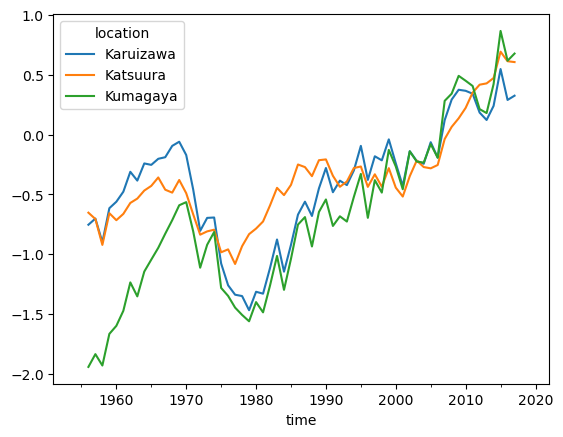

In [36]:
df5.plot()